# Setting

In [57]:
import numpy as np
import tensorflow as tf
import iris
import matplotlib.pyplot as plt
from neural_network_decision_tree import nn_decision_tree
import pandas as pd
import xgboost as xgb
import math
from sklearn.model_selection import train_test_split 
import sklearn.metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

# Load Data

In [51]:
data = pd.read_excel (r'Kaggle_Sirio_Libanes_ICU_Prediction.xlsx') 
print(data.isnull().sum())

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     748
TEMPERATURE_DIFF_REL          694
OXYGEN_SATURATION_DIFF_REL    686
WINDOW                          0
ICU                             0
Length: 231, dtype: int64


# EDA & Data Prepaertion

In [52]:
missing_data = (data.isnull().sum())/data.shape[0]
# print(len(missing_data))

inputs = data.drop(['AGE_PERCENTIL', 'ICU', 'WINDOW'], axis=1)
y = data['ICU']
imputed_data = pd.DataFrame(columns=inputs.columns)

for index, row in inputs.iterrows():
    
    if index == 0: 
        temp_values = row.to_dict() 
  
    for col in inputs.columns:
        if math.isnan(float(row[col])):
            row[col] = temp_values[col]
      
    
    imputed_data = imputed_data.append(row.to_dict(), ignore_index=True)
    temp_values = row.to_dict()
    
print("____________________________________________________")          
print(imputed_data.isnull().sum())


____________________________________________________
PATIENT_VISIT_IDENTIFIER           0
AGE_ABOVE65                        0
GENDER                             0
DISEASE GROUPING 1                 0
DISEASE GROUPING 2                 0
                                  ..
BLOODPRESSURE_SISTOLIC_DIFF_REL    0
HEART_RATE_DIFF_REL                0
RESPIRATORY_RATE_DIFF_REL          0
TEMPERATURE_DIFF_REL               0
OXYGEN_SATURATION_DIFF_REL         0
Length: 228, dtype: int64


# XGBoost

In [53]:
# train/test split data
print(y.sum()/ len(y)) # 27% patients do have readmissions

X_train, X_test, y_train, y_test = train_test_split(inputs, data['ICU'], random_state = 42, stratify = y )


0.2675324675324675


In [54]:
clf_xgb = xgb.XGBClassifier(Objective = 'binary:logistic', missing = None, seed=42)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds = 10, eval_metric='aucpr', eval_set = [(X_test, y_test)])

[14:37:13] WARNING: ..\src\learner.cc:541: 
Parameters: { Objective } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.79236
[1]	validation_0-aucpr:0.80426
[2]	validation_0-aucpr:0.81748
[3]	validation_0-aucpr:0.84472
[4]	validation_0-aucpr:0.84524
[5]	validation_0-aucpr:0.85373
[6]	validation_0-aucpr:0.85243
[7]	validation_0-aucpr:0.86018
[8]	validation_0-aucpr:0.86254
[9]	validation_0-aucpr:0.86399
[10]	validation_0-aucpr:0.86538
[11]	validation_0-aucpr:0.86597
[12]	validation_0-aucpr:0.87007
[13]	validation_0-aucpr:0.87291
[14]	validation_0-aucpr:0.87329


C:\Users\mkmag\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-aucpr:0.87765
[16]	validation_0-aucpr:0.88390
[17]	validation_0-aucpr:0.88360
[18]	validation_0-aucpr:0.88338
[19]	validation_0-aucpr:0.88588
[20]	validation_0-aucpr:0.88703
[21]	validation_0-aucpr:0.89007
[22]	validation_0-aucpr:0.89109
[23]	validation_0-aucpr:0.89262
[24]	validation_0-aucpr:0.89248
[25]	validation_0-aucpr:0.89489
[26]	validation_0-aucpr:0.89391
[27]	validation_0-aucpr:0.89325
[28]	validation_0-aucpr:0.89370
[29]	validation_0-aucpr:0.89294
[30]	validation_0-aucpr:0.89262
[31]	validation_0-aucpr:0.89281
[32]	validation_0-aucpr:0.89232
[33]	validation_0-aucpr:0.89262
[34]	validation_0-aucpr:0.89252
[35]	validation_0-aucpr:0.89248


XGBClassifier(Objective='binary:logistic', base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

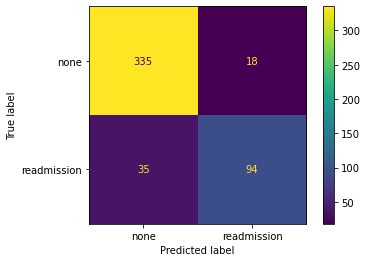

In [55]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', display_labels=['none', 'readmission'])


## Conclusion 
<b> XGBoost</b> is not awsome for this probelm, maybe because our data is imbalanced.
Let's use scale_pos_weight that gives penalty for incorrectly classifying minority class. 

### If the data is imbalanced: XGBoost says :
<p>1- Use AUC for validation <br>
2- Balance the positive and negetive weights via scale_pos_weight </p>


In [18]:
# param_grid = {
#     'max_depth': [3, 4, 5, 6, 7],
#     'learning_rate': [0.1, 0.01, 0.05],
#     'gamma' : [0, 0.25, 1.0],
#     'reg_lamda' : [0, 1.0, 10.0],
#     'scale_pos_weight': [1, 3, 5]
# }

# #Note: to speed up CV and further prevents overfitting, we are using a random subset of data (90%), and random 
# # subset of features(50%) per tree. 

# optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed = 42, subsample = 0.9, colsammple_bytree = 0.5), param_grid = param_grid, scoring = 'roc_auc', verbose = 0, n_jobs = 10, cv = 3)
# optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)
# print(optimal_params.best_params_)

C:\Users\mkmag\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:30:17] WARNING: ..\src\learner.cc:541: 
Parameters: { colsammple_bytree, reg_lamda } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lamda': 0, 'scale_pos_weight': 1}


{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lamda': 0, 'scale_pos_weight': 1}

In [30]:
clf_xgb = xgb.XGBClassifier(Objective = 'binary:logistic', seed=42, gamma=0, learn_rate = 0.1, 
                           max_depth = 7,
                           reg_lambda = 0,
                           scale_pos_weight = 1, 
                           subsample = 0.9, colsample_bytree = 0.5)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds = 10, eval_metric='aucpr', eval_set = [(X_test, y_test)])

[13:20:16] WARNING: ..\src\learner.cc:541: 
Parameters: { Objective, learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.66944
[1]	validation_0-aucpr:0.74130
[2]	validation_0-aucpr:0.69355
[3]	validation_0-aucpr:0.75446
[4]	validation_0-aucpr:0.78378
[5]	validation_0-aucpr:0.80066
[6]	validation_0-aucpr:0.81674
[7]	validation_0-aucpr:0.81799
[8]	validation_0-aucpr:0.82485
[9]	validation_0-aucpr:0.82983
[10]	validation_0-aucpr:0.83725
[11]	validation_0-aucpr:0.84306
[12]	validation_0-aucpr:0.84830
[13]	validation_0-aucpr:0.85023
[14]	validation_0-aucpr:0.85053
[15]	validation_0-aucpr:0.85389
[16]	validation_0-aucpr:0.85392
[17]	validation_0-aucpr:0.86089


C:\Users\mkmag\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18]	validation_0-aucpr:0.86194
[19]	validation_0-aucpr:0.86140
[20]	validation_0-aucpr:0.86209
[21]	validation_0-aucpr:0.86525
[22]	validation_0-aucpr:0.86682
[23]	validation_0-aucpr:0.87095
[24]	validation_0-aucpr:0.87555
[25]	validation_0-aucpr:0.87499
[26]	validation_0-aucpr:0.87468
[27]	validation_0-aucpr:0.87374
[28]	validation_0-aucpr:0.87410
[29]	validation_0-aucpr:0.87498
[30]	validation_0-aucpr:0.87550
[31]	validation_0-aucpr:0.87473
[32]	validation_0-aucpr:0.87333
[33]	validation_0-aucpr:0.87519
[34]	validation_0-aucpr:0.87413


XGBClassifier(Objective='binary:logistic', base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learn_rate=0.1,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

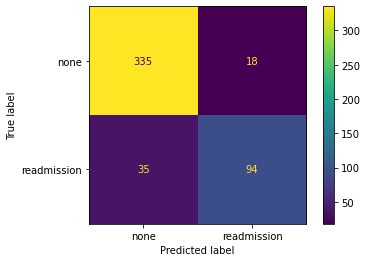

In [31]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', display_labels=['none', 'readmission'])

# Q1:
why the evaluation metric afeter gridsearch gets less?

# ROC Curve 
The ROC curve plots False Positive Rate on the X-axis and the True Positive Rate on the Y-axis

<br>
TPR(Sensitivity) = TP/(TP+FN)
<br>
FPR(1-Specificity) = FP/(TN+FP)

<b> Totaly 353 patients did not return back to the ICU and 335 didn't in real, means the accuray is 0.94. 
and 129 of them had readmission and 0.72 of them has modeled correctly.</b>

FP : Type | Error : 18<br>
FN : Type || Error : 35 <br>
Accuracy : 94 + 335/ (94+335+18+35) = 0.89



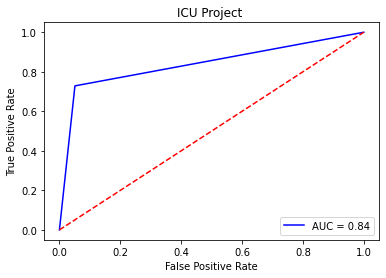

In [56]:
y_test_pred = clf_xgb.predict(X_test)


def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ICU Project ')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.gcf().savefig('roc.png')
    plt.show()
    
buildROC(y_test, y_test_pred)